In [1]:
import torch
import numpy as np
from sklearn.datasets import load_files
from glob import glob
import cv2 # type: ignore
import matplotlib.pyplot as plt

%matplotlib inline
import random
import os

In [2]:
#狗的数据集
def load_data(path): 
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = torch.nn.functional.one_hot(torch.tensor(np.array(data['target'])).long(),133)  # 将类别转换成数组。
    print(dog_targets.shape)
    return dog_files,dog_targets
train_files,train_targets = load_data('../dogImages/train')
valid_files,valid_targets = load_data('../dogImages/valid')  
test_files,test_targets = load_data('../dogImages/test')
dog_names = [item[20:-1] for item in sorted(glob("../dogImages/train/*/"))]


torch.Size([6680, 133])
torch.Size([835, 133])
torch.Size([836, 133])


In [3]:
#人脸的数据集
random.seed(8675309)
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)  #type:ignore

In [4]:
#人脸检测模型加载
face_cascade = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_alt.xml') # type: ignore


In [5]:
def face_detector(img_path):
    img = cv2.imread(img_path) #type:ignore
    if img is not None:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #type:ignore
        faces = face_cascade.detectMultiScale(gray)
    
    #圈出模型识别出的人脸在图中位置。
    for(x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1) # type: ignore
    cv_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # type: ignore
    plt.imshow(cv_rgb)
    plt.show()
    plt.close()
    return faces
    

In [6]:
face_detection = []
for i in human_files:
    for j in os.listdir(i):
        face_detection.append(face_detector(os.path.join(i,j)))

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [8]:
def model_ignores(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #type:ignore
    detect_face = len(face_cascade.detectMultiScale(gray)) # type: ignore
    return detect_face>0

In [9]:
error_num=0
for i in human_files_short:
    for j in os.listdir(i):
        detect_face = model_ignores(os.path.join(i,j))
        if(detect_face==False):
            error_num+=1;
            print("human_files[{}] detect human face fail".format(os.path.join(i,j)))
print("error check number:{}".format(error_num))
error_num=0
for i in dog_files_short:
    detect_face = model_ignores(i)
    if(detect_face==True):
        error_num+=1
        print("dog_files[{}] is detectted as human face".format(i))
print("error check number:{}".format(error_num))

error check number:0
dog_files[../dogImages/train\095.Kuvasz\Kuvasz_06442.jpg] is detectted as human face
dog_files[../dogImages/train\099.Lhasa_apso\Lhasa_apso_06646.jpg] is detectted as human face
dog_files[../dogImages/train\009.American_water_spaniel\American_water_spaniel_00628.jpg] is detectted as human face
dog_files[../dogImages/train\057.Dalmatian\Dalmatian_04023.jpg] is detectted as human face
dog_files[../dogImages/train\096.Labrador_retriever\Labrador_retriever_06474.jpg] is detectted as human face
dog_files[../dogImages/train\106.Newfoundland\Newfoundland_06989.jpg] is detectted as human face
dog_files[../dogImages/train\117.Pekingese\Pekingese_07559.jpg] is detectted as human face
dog_files[../dogImages/train\039.Bull_terrier\Bull_terrier_02805.jpg] is detectted as human face
dog_files[../dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06516.jpg] is detectted as human face
dog_files[../dogImages/train\057.Dalmatian\Dalmatian_04086.jpg] is detectted as human face
dog

In [10]:
#使用ResNet-50模型
import torch.nn as nn

In [11]:
import torch
import torch.nn as nn
#第一层神经网络结构
class InitialBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(InitialBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
#残差神经网络结构
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckResidualBlock, self).__init__()
        bottleneck_channels = out_channels // 4
        
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        out += self.shortcut(residual)
        # 如果shortcut非空，应用shortcut并且调整输入的通道数以匹配输出
        if self.shortcut:
            residual = self.shortcut(residual)
        out += residual
        out = self.relu3(out)

        return out
#ResNet网络结构第一层和残差层继续组合
class ResidualStage(nn.Module):
    def __init__(self, in_channels, out_channels, block, blocks_num, stride=1):
        super(ResidualStage, self).__init__()
        self.blocks = nn.ModuleList([block(in_channels, out_channels, stride)] +
                                    [block(out_channels, out_channels) for _ in range(1, blocks_num)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes=133):
        super(ResNet,self).__init__()
        self.initial_block=InitialBlock(in_channels=3, out_channels=64)
        self.stage0 = ResidualStage(in_channels=64, out_channels=256, block=block, blocks_num=layers[0])
        self.stage1 = ResidualStage(in_channels=256, out_channels=612, block=block, blocks_num=layers[1], stride=2)
        self.stage2 = ResidualStage(in_channels=612, out_channels=1024, block=block, blocks_num=layers[2], stride=2)
        self.stage3 = ResidualStage(in_channels=1024, out_channels=2048, block=block, blocks_num=layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
    def forward(self,x):
        x = self.initial_block(x)
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
# 创建 ResNet-50 模型
resnet50 = ResNet(BottleneckResidualBlock, [3, 4, 6, 3])

In [12]:
resnet50

ResNet(
  (initial_block): InitialBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage0): ResidualStage(
    (blocks): ModuleList(
      (0): BottleneckResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [13]:
import cv2
import torch
import numpy as np
from os import walk
import os
from torch.utils.data import DataLoader
from torchvision import transforms
import random  # 导入 random 模块

# 示例用法
image_dir = '../dogImages/train'
batch_size = 32

# Create class to index dictionary
class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(image_dir))}

def load_images(image_dir, batch_size=32):
    """
    将图像加载为张量并以批处理为单位返回，并将标签转换为整数编码。

    Args:
        image_dir (str): 图像目录。
        batch_size (int): 批处理大小。

    Returns:
        list of tuple: 图像张量批处理和标签整数编码批处理列表。
    """
    num_classes = len(os.listdir(image_dir))  # 获取类别数量

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 5.0, 5.0], std=[0.5, 0.5, 0.5])  # Mean and std adjusted for RGB
    ])

    images = []
    labels = []  # 存储整数编码的标签

    # 获取图像文件列表并随机打乱顺序
    file_list = []
    for root, _, filenames in walk(image_dir):
        for filename in filenames:
            file_list.append(os.path.join(root, filename))
    random.shuffle(file_list)

    for file_path in file_list:
        label = os.path.basename(os.path.dirname(file_path))  # 从文件路径中提取标签

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Convert NumPy array to PIL Image before applying transforms
        image = transforms.ToPILImage()(image)

        # Apply transformations using the defined transform object
        image = transform(image)

        images.append(image)

        # Convert label to integer encoding
        label_idx = class_to_idx[label]
        labels.append(label_idx)

        if len(images) == batch_size:
            yield torch.stack(images, dim=0), torch.tensor(labels)  # 返回整数编码的标签
            images = []
            labels = []

    if images:
        yield torch.stack(images, dim=0), torch.tensor(labels)  # 返回整数编码的标签


# for images, labels in load_images(image_dir, batch_size=batch_size):
#     print(images, labels)  # 输出：[32, 3, 224, 224], [32]


c:\python\envs\Torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
s = load_images(image_dir)

In [15]:
count =0
for i,j in s:
    # print(i.shape[0])
    count = count+i.shape[0]
    

In [16]:
#定义损失函数，优化器和超参数
batch_size = 32
learning_rate=0.1
num_epochs=25
import torch.optim as optim
# 定义损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(),lr=learning_rate)


In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

epoch:0
Epoch [1/25], Loss: 4.9265
epoch:1
Epoch [2/25], Loss: 4.9227
epoch:2
Epoch [3/25], Loss: 4.9223
epoch:3
Epoch [4/25], Loss: 4.9231
epoch:4
Epoch [5/25], Loss: 4.9187
epoch:5
Epoch [6/25], Loss: 4.9229
epoch:6
Epoch [7/25], Loss: 4.9189
epoch:7
Epoch [8/25], Loss: 4.9221
epoch:8
Epoch [9/25], Loss: 4.9181
epoch:9
Epoch [10/25], Loss: 4.9185
epoch:10
Epoch [11/25], Loss: 4.9212
epoch:11
Epoch [12/25], Loss: 4.9214
epoch:12
Epoch [13/25], Loss: 4.9225
epoch:13
Epoch [14/25], Loss: 4.9221
epoch:14
Epoch [15/25], Loss: 4.9189
epoch:15
Epoch [16/25], Loss: 4.9184
epoch:16
Epoch [17/25], Loss: 4.9180
epoch:17
Epoch [18/25], Loss: 4.9177
epoch:18
Epoch [19/25], Loss: 4.9210
epoch:19
Epoch [20/25], Loss: 4.9179
epoch:20
Epoch [21/25], Loss: 4.9168
epoch:21
Epoch [22/25], Loss: 4.9211
epoch:22
Epoch [23/25], Loss: 4.9214
epoch:23
Epoch [24/25], Loss: 4.9169
epoch:24
Epoch [25/25], Loss: 4.9194


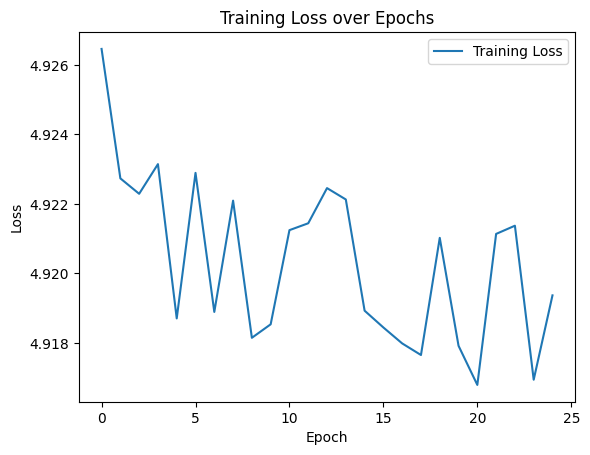

In [131]:
from tqdm import tqdm  # 导入 tqdm 库

train_losses = []
for epoch in range(num_epochs):
    resnet50.train()
    running_loss=0.0
    total_samples = 0
    print(f"epoch:{epoch}")
    try:
        for inputs,labels in load_images(image_dir):
            optimizer.zero_grad()
            outputs = resnet50(inputs)
            # print(outputs[0])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # 计算当前批次的损失并累加到 running_loss 中
            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    except OSError as e:
        print(f"OSError occurred: {e}")
        pass
    
    # 计算当前epoch的平均损失
    epoch_loss = running_loss / total_samples
    train_losses.append(epoch_loss)
    
    # 输出当前epoch的损失
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
# 绘制损失函数的图表
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [132]:
# 保存模型参数和梯度
torch.save({
    'model_state_dict': resnet50.state_dict(),  # 保存模型参数
    'optimizer_state_dict': optimizer.state_dict(),  # 保存优化器状态
    'optimizer_gradient': optimizer.state_dict()['param_groups'][0]['params'],  # 保存优化器的梯度
    'loss': loss.item(),  # 保存损失函数的值
    # 这里你也可以保存其他信息，比如训练的轮数、模型的超参数等
    }, 'my_model.pth')

# 如果要保存超参数，你可以将超参数保存为一个字典
hyperparameters = {
    'learning_rate': 0.01,
    'batch_size': 32,
    # 其他超参数...
}

torch.save(hyperparameters, 'hyperparameters.pth')

In [20]:
models = torch.load('hyperparameters.pth',map_location=torch.device('cuda'))

In [22]:
#torch自带模型和自己生成模型对比

In [ ]:
import torchvision
from torchvision import models
resnet50 = models.resnet50(pretrained=True,weights='')
print(resnet50)

In [133]:
test_data="../dogImages/test"

In [134]:
# 计算测试集上的精度
correct = 0
total = 0
with torch.no_grad():
    for inputs,labels in load_images(test_data,1):
        outputs = resnet50(inputs)
        # print(f"predict:{torch.argmax(outputs)},origin:{labels.item()}")
        total+=1
        if torch.argmax(outputs)==labels.item():
            correct=correct+1

print('测试精度: {:.2f}%'.format(100 * correct / total))

测试精度: 0.84%


In [20]:
resnet50.eval()
test_data ='../dogImages/test' 

In [21]:
criterion = nn.CrossEntropyLoss()